Importing Necessary Libraries

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk as nk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

load the dataset

In [108]:
df= pd.read_csv('/home/bek/Desktop/KAiM/KAIM-W1/data/raw_analyst_ratings.csv')

In [55]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [56]:
df.shape

(1407328, 6)

In [57]:
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

### Descriptive Statistics

##### Headline Length Analysis

In [58]:
df['headline_length'] = df['headline'].apply(lambda x: len(x.split()))
df['headline_length'].head()

0     7
1     7
2     5
3     7
4    14
Name: headline_length, dtype: int64

In [89]:
df['headline_length'].describe()

count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_length, dtype: float64

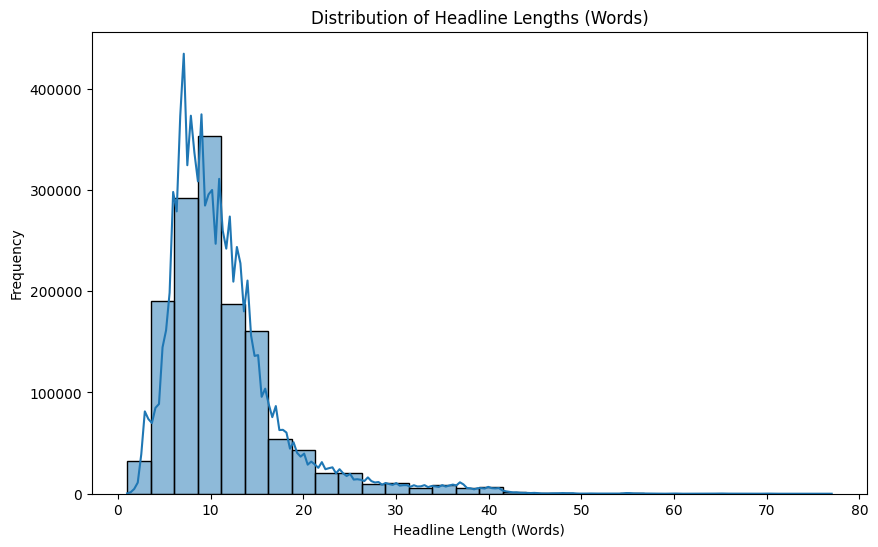

In [59]:
# Visualize headline length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths (Words)')
plt.xlabel('Headline Length (Words)')
plt.ylabel('Frequency')
plt.show()

##### Articles per Publisher

In [90]:
# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


##### Publication Date Analysis

In [110]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')

# Extract date parts
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()


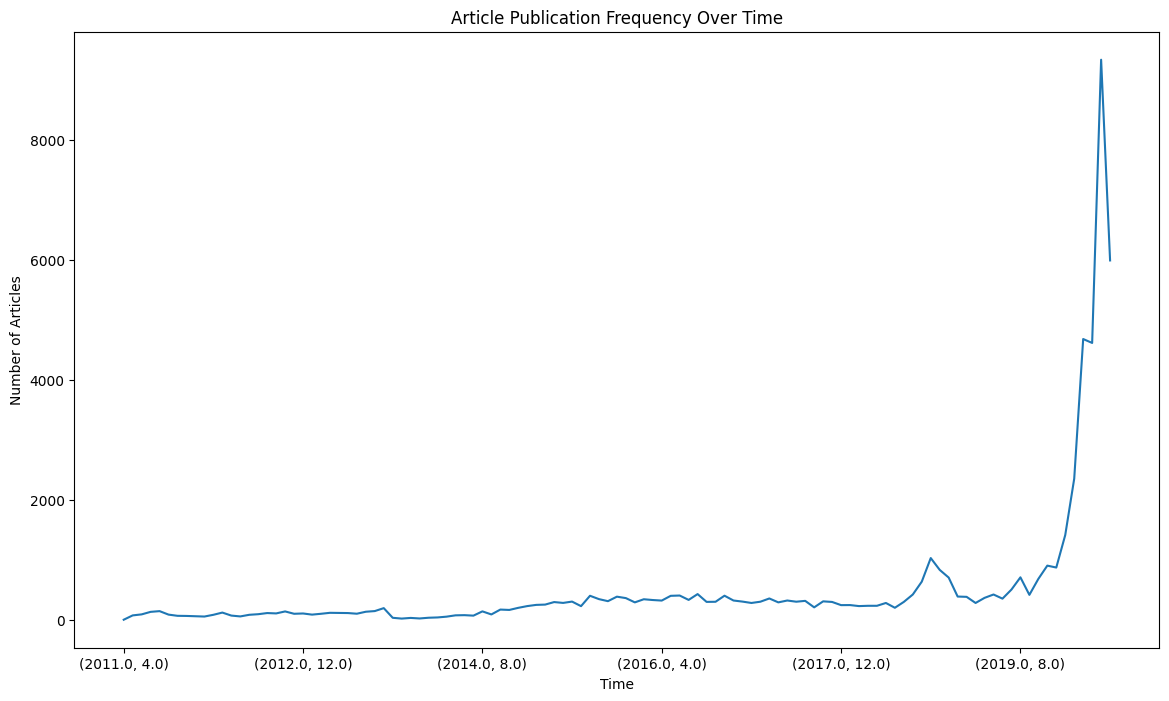

In [111]:
# Analyze the publication date trends
publication_trends = df.groupby(['year', 'month']).size()

# Visualize publication frequency over time
plt.figure(figsize=(14, 8))
publication_trends.plot(kind='line')
plt.title('Article Publication Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Articles')
plt.show()

### Sentiment analysis on Headlines

In [95]:
nk.download('punkt')

[nltk_data] Downloading package punkt to /home/bek/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [123]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [124]:
df['sentiment'] = df['headline'].apply(get_sentiment)

In [125]:
print(df[['headline', 'sentiment']].head())

                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   

                          sentiment  
date                                 
2020-06-05 14:30:54+00:00   Neutral  
2020-06-03 14:45:20+00:00   Neutral  
2020-05-26 08:30:07+00:00   Neutral  
2020-05-22 16:45:06+00:00   Neutral  
2020-05-22 15:38:59+00:00   Neutral  


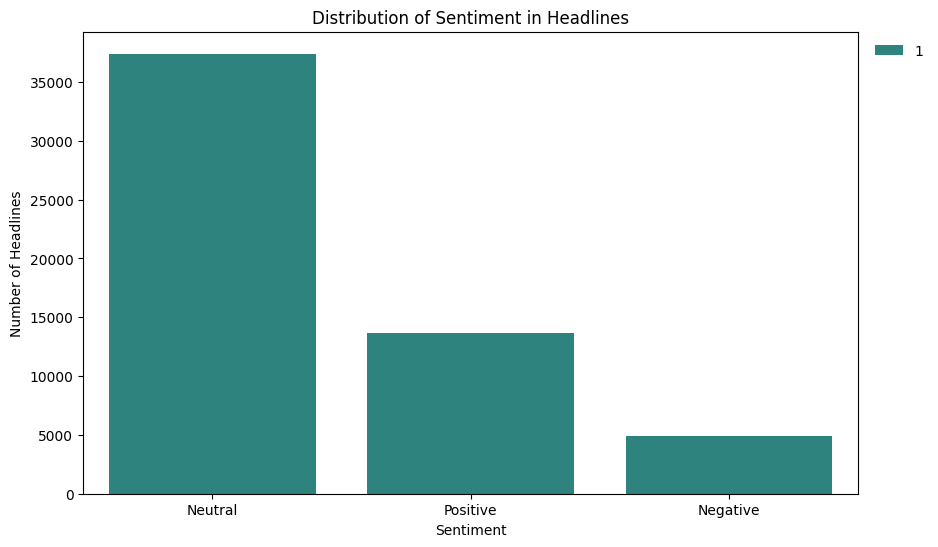

In [128]:
# Create a count plot for sentiment distribution
plt.figure(figsize=(10, 6))

# Use countplot to visualize the sentiment distribution with a dummy hue variable
sns.countplot(x='sentiment', hue=1, data=df, palette='viridis')

# Add titles and labels
plt.title('Distribution of Sentiment in Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')

# Remove the legend as it's not necessary for this plot
plt.legend(title=None, loc='upper right', bbox_to_anchor=(1.1, 1), frameon=False)

# Show the plot
plt.show()

### Identify common keywords

In [132]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # unigram and bigram
tfidf_matrix = tfidf_vectorizer.fit_transform(df['headline'])

# Get feature names and scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Create a DataFrame to display the keywords and their scores
keywords_df = pd.DataFrame({'Keyword': feature_names, 'Score': tfidf_scores})
keywords_df = keywords_df.sort_values(by='Score', ascending=False)

# Show the top 10 keywords
print(keywords_df.head(10))

           Keyword        Score
136754      stocks  2029.002142
15101           52  1800.370458
152724        week  1798.930189
15155      52 week  1791.237891
77571          hit  1618.383143
136869  stocks hit  1617.334004
77575       hit 52  1617.180722
90455         lows  1173.336269
152797   week lows  1172.826192
142633    thursday   900.490127


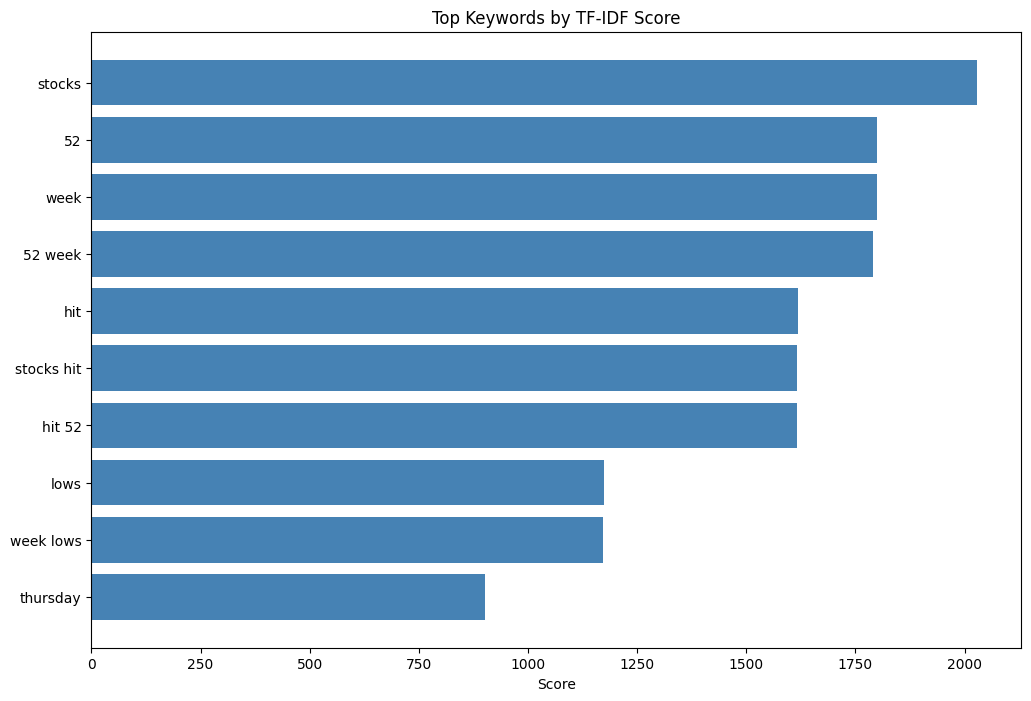

In [137]:
# Plot the top keywords
plt.figure(figsize=(12, 8))
top_keywords = keywords_df.head(10)
plt.barh(top_keywords['Keyword'], top_keywords['Score'], color='steelblue')
plt.xlabel('Score')
plt.title('Top Keywords by TF-IDF Score')
plt.gca().invert_yaxis()
plt.show()

### Time Series Analysis

/tmp/ipykernel_21377/2503852486.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.resample('M').size()


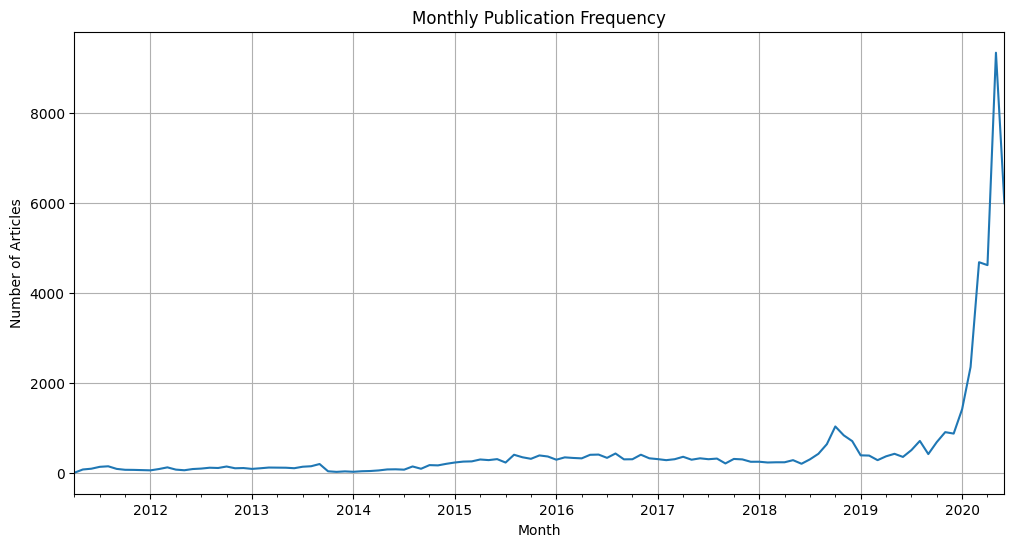

In [118]:

df.dropna(subset=['date'], inplace=True)
df.set_index('date', inplace=True)
monthly_counts = df.resample('M').size()

# Plot monthly publication counts
plt.figure(figsize=(12, 6))
monthly_counts.plot(title='Monthly Publication Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()


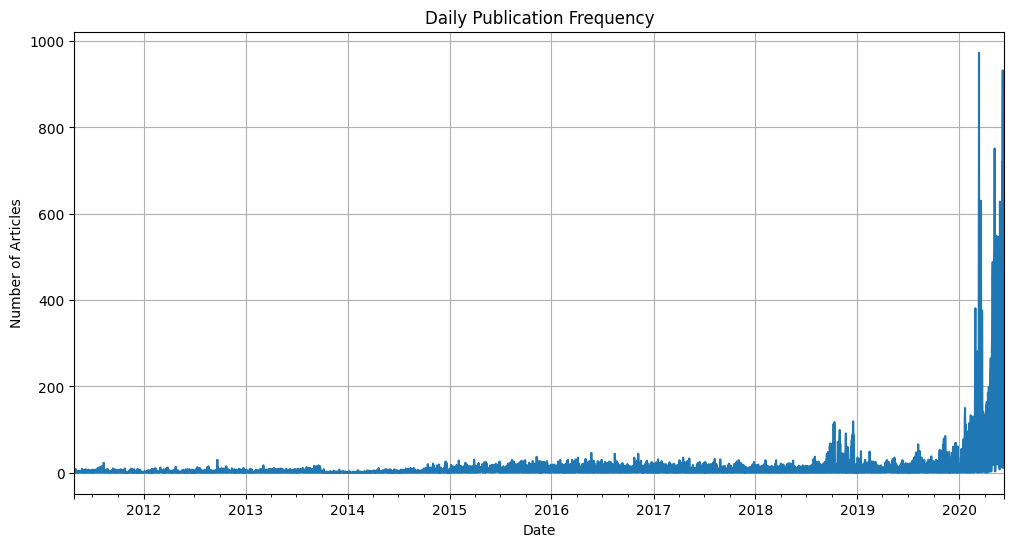

In [119]:
daily_counts = df.resample('D').size()

# Plot daily publication counts
plt.figure(figsize=(12, 6))
daily_counts.plot(title='Daily Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

### publisher analysis

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


/tmp/ipykernel_21377/2453481343.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.index, y=top_publishers.values, palette='viridis')


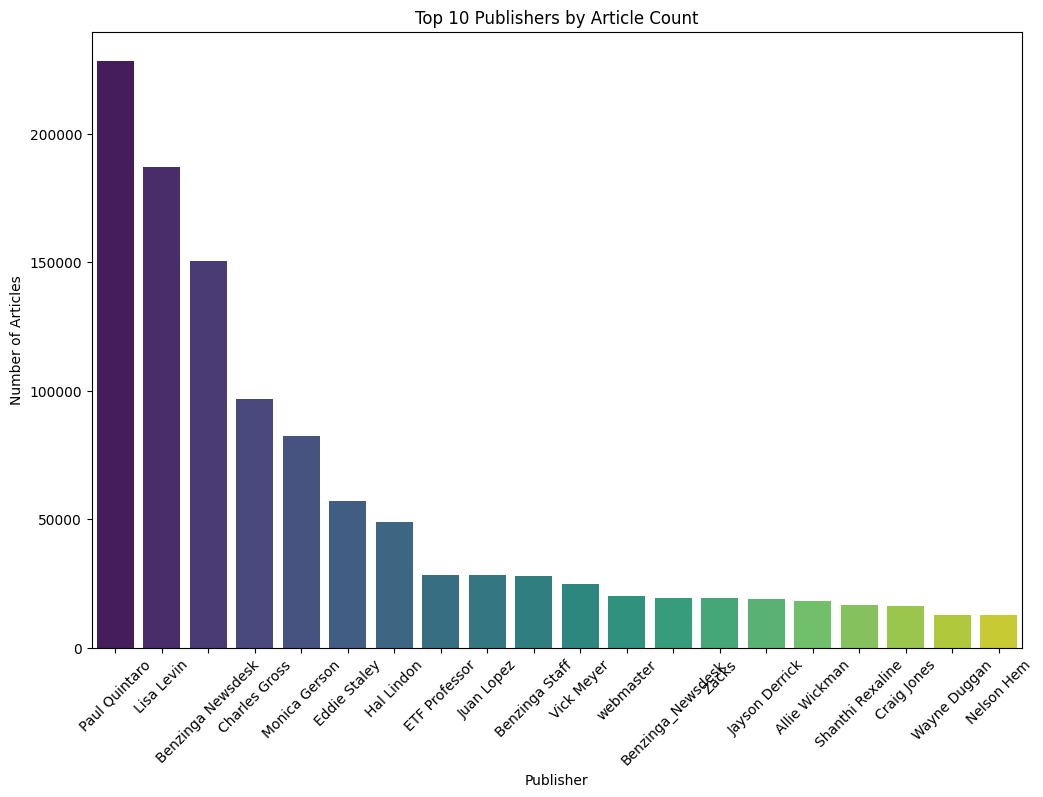

In [92]:
# Top publishers
top_publishers = publisher_counts.head(20)
print(top_publishers)

# Visualize the number of articles per top publisher
plt.figure(figsize=(12, 8))
sns.barplot(x=top_publishers.index, y=top_publishers.values, palette='viridis')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

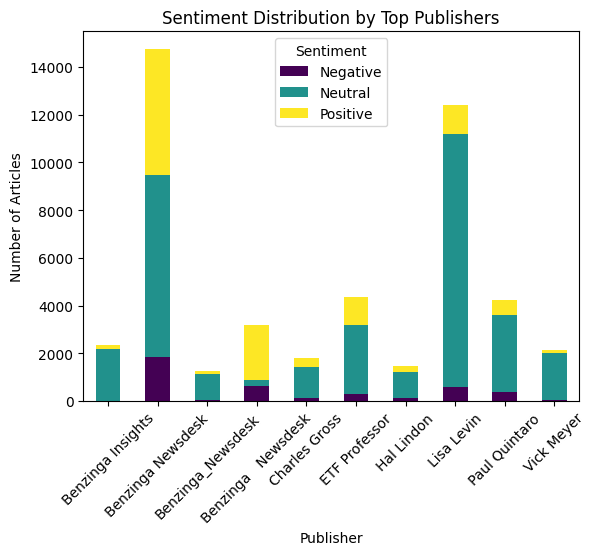

In [140]:
# Count the number of articles per publisher
publisher_stats = df['publisher'].value_counts().head(10)

# Count the number of articles for each sentiment category by publisher
sentiment_counts = df[df['publisher'].isin(publisher_stats.index)].groupby(['publisher', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment distribution by publisher
plt.figure(figsize=(12, 8))
sentiment_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sentiment Distribution by Top Publishers')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()


In [149]:
# Calculate the percentage of each sentiment category by publisher
sentiment_percentage = sentiment_counts.divide(sentiment_counts.sum(axis=1), axis=0) * 100
sentiment_percentage.mean()

sentiment
Negative     7.574133
Neutral     70.655493
Positive    21.770373
dtype: float64

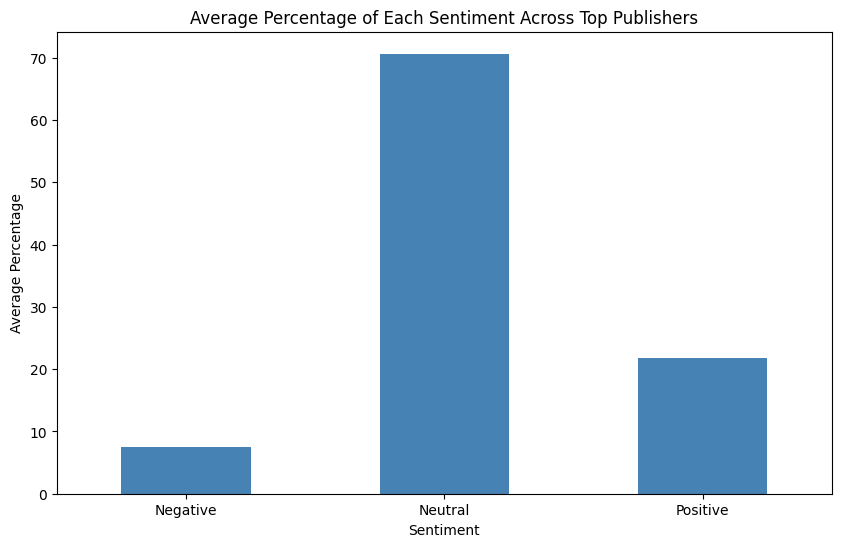

In [148]:
# Calculate the mean percentage of each sentiment category across all top publishers
mean_sentiment_percentage = sentiment_percentage.mean()

# Plot the average sentiment percentages
plt.figure(figsize=(10, 6))
mean_sentiment_percentage.plot(kind='bar', color='steelblue')
plt.title('Average Percentage of Each Sentiment Across Top Publishers')
plt.xlabel('Sentiment')
plt.ylabel('Average Percentage')
plt.xticks(rotation=0)
plt.show()

In [122]:
# If publisher names are emails, extract domains
df['domain'] = df['publisher'].str.extract(r'@([a-zA-Z0-9.-]+)')

# Check if the extraction was successful
df[['publisher', 'domain']].head()

# Count unique domains
domain_counts = df['domain'].value_counts().head(1)
domain_counts


domain
benzinga.com    1196
Name: count, dtype: int64